In [132]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


In [133]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt


In [134]:
from skimage.feature import hog, local_binary_pattern
from skimage import data, exposure
from skimage.feature import graycomatrix, graycoprops
from scipy import signal as sg

def extract_color_histogram(image, bins=(8, 8, 8)):
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

def extract_lbp(image, num_points=8, radius=1):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, num_points, radius, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, num_points + 51), range=(0, num_points + 50))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist.flatten()

# def extract_glcm(image):
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     glcm = mahotas.features.haralick(gray).mean(axis=0)
#     return glcm

def extract_glcm(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    glcm = graycomatrix(gray, [1], angles=[np.pi/4], symmetric=True, normed=True)
    #좌우 , 대각, 위아래 세가지 경우를 확인해볼것
    contrast = graycoprops(glcm, 'contrast')
    dissimilarity = graycoprops(glcm, 'dissimilarity')
    homogeneity = graycoprops(glcm, 'homogeneity')
    energy = graycoprops(glcm, 'energy')
    correlation = graycoprops(glcm, 'correlation')
    asm = graycoprops(glcm, 'ASM')
    return np.hstack([contrast, dissimilarity, homogeneity, energy, correlation, asm]).flatten()
#차이점  각각의 요소의 0,0 벡터만 뽑음


def extract_hog(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # gray = cv2.Canny(gray, 100, 200)
    features, hog_image = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True)
    # # fd: 8 * (image.shape[0]//16)*(image.shape[1]//16) dimension
    # fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
    #                 cells_per_block=(1, 1), visualize=True, channel_axis=-1)
    # hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    return features


def laws_texture(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    (rows, cols) = gray.shape[:2]

    smooth_kernel = (1/25) * np.ones((5,5))
    gray_smooth = sg.convolve(gray, smooth_kernel, "same")
    gray_processed = np.abs(gray - gray_smooth)

    filter_vectors = np.array([[ 1,  4,  6,  4, 1],    # L5
                               [-1, -2,  0,  2, 1],    # E5
                               [-1,  0,  2,  0, 1],    # S5
                               [ 1, -4,  6, -4, 1]])   # R5

    filters = []
    for i in range(4):
        for j in range(4):
            filters.append(np.outer(filter_vectors[i], filter_vectors[j]))

    conv_maps = np.zeros((rows, cols, 16))
    for i in range(len(filters)):
        conv_maps[:, :, i] = sg.convolve(gray_processed, filters[i], "same")

    texture_maps = []
    texture_maps.append((conv_maps[:, :, 1] + conv_maps[:, :, 4]) // 2)     # L5E5 / E5L5
    texture_maps.append((conv_maps[:, :, 2] + conv_maps[:, :, 8]) // 2)     # L5S5 / S5L5
    texture_maps.append((conv_maps[:, :, 3] + conv_maps[:, :, 12]) // 2)    # L5R5 / R5L5
    texture_maps.append((conv_maps[:, :, 7] + conv_maps[:, :, 13]) // 2)    # E5R5 / R5E5
    texture_maps.append((conv_maps[:, :, 6] + conv_maps[:, :, 9]) // 2)     # E5S5 / S5E5
    texture_maps.append((conv_maps[:, :, 11] + conv_maps[:, :, 14]) // 2)   # S5R5 / R5S5
    texture_maps.append(conv_maps[:, :, 10])                                # S5S5
    texture_maps.append(conv_maps[:, :, 5])                                 # E5E5
    texture_maps.append(conv_maps[:, :, 15])                                # R5R5
    texture_maps.append(conv_maps[:, :, 0])                                 # L5L5 (use to norm TEM)

    TEM = []
    for i in range(9):
        TEM.append(np.abs(texture_maps[i]).sum() / np.abs(texture_maps[9]).sum())

    return TEM

def extract_harris_corners(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    corners = cv2.cornerHarris(gray, 2, 3, 0.04)
    # 결과 이미지 확대 (디스플레이 목적)
    corners = cv2.dilate(corners, None)
    image[corners > 0.01 * corners.max()] = [0, 0, 255]
    return corners.flatten()
def extract_sift(image, fixed_size=200):
    sift = cv2.SIFT_create()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    if descriptors is None:
        descriptors = np.zeros((1, 128))
    descriptors = descriptors[:fixed_size]
    if len(descriptors) < fixed_size:
        descriptors = np.pad(descriptors, ((0, fixed_size - len(descriptors)), (0, 0)), 'constant')
    mean_descriptor = np.mean(descriptors, axis=0)
    return mean_descriptor.flatten()
def extract_sift_features(image):
    sift = cv2.SIFT_create()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    return descriptors
def extract_canny(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    return edges.flatten()
def extract_sobel(image):
  # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply Sobel filter
    edge_sobelx = cv2.Sobel(gray, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=3)
    edge_sobely = cv2.Sobel(gray, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=3)
    # Combine the edge results
    edges = cv2.magnitude(edge_sobelx, edge_sobely)
    edges = cv2.convertScaleAbs(edges)
    return edges.flatten()

In [135]:
#Color Histogram + SIFT + HOG
#각각을 차원 축소하는건 어떠한가?

def extract_features(image):
    # 각 특성 추출
    color_hist = extract_color_histogram(image)
    lbp = extract_lbp(image)
    # glcm = extract_glcm(image)
    hog = extract_hog(image)
    # laws = laws_texture(image)
    # harris_corners = extract_harris_corners(image)
    sift = extract_sift(image)
    canny = extract_canny(image)
    # sobel = extract_sobel(image)

    # 모든 특징 벡터를 하나의 리스트로 결합
    # features = np.hstack([color_hist, lbp, glcm, hog, laws, harris_corners, sift, canny])
    features = np.hstack([color_hist,lbp,hog,canny,sift])
    # return reduced_features.flatten()
    return features

In [ ]:
# '''
#     i j
# '''
# #좌우로 있는 픽셀 비교
# glcm = graycomatrix(gray, distances=[1], angles=[0], levels=256, symmetric=False, normed=True)

# '''
#     i
#     j
# '''
# #위아래에 있는 픽셀 비교
# glcm = graycomatrix(gray, distances=[1], angles=[np.pi/2], levels=256, symmetric=False, normed=True)

# '''
#     i
#       j
# '''
# #대각선 위치의 픽셀 비교
# glcm = graycomatrix(gray, distances=[1], angles=[np.pi/4], levels=256, symmetric=False, normed=True)

### KNN 과정


In [ ]:
# 히스토그램 평활화, 가우시안 블러, 엣지 추출 . morphology
# 애매한 이미지는 제거, multi-label은 어떻게 할 것인지.
def preprocessing(image):

    denoised_image = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)

    # Sharpen the image
    kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])
    sharpened_image = cv2.filter2D(denoised_image, -1, kernel)

    # Brightness and contrast adjustment using CLAHE
    lab = cv2.cvtColor(sharpened_image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    final_image = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    # final_image = cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB)

    # # Convert to grayscale
    # gray = cv2.cvtColor(final_image, cv2.COLOR_BGR2GRAY)

    # # Apply Sobel filter
    # edge_sobelx = cv2.Sobel(gray, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=3)
    # edge_sobely = cv2.Sobel(gray, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=3)

    # # Combine the edge results
    # edges = cv2.magnitude(edge_sobelx, edge_sobely)
    # edges = cv2.convertScaleAbs(edges)

    # edges_canny = cv2.Canny(sharpened_image, 100, 200)
    return cv2.resize(final_image, (120, 120))

###전처리 test


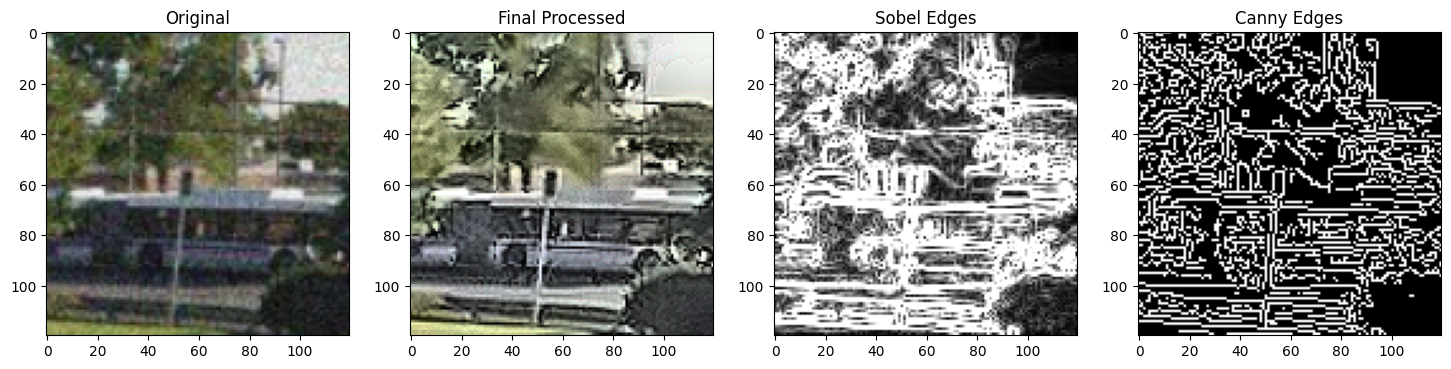

In [ ]:
#image = cv2.imread('/content/recaptcha-dataset/Bicycle/Bicycle (10).png')
image = cv2.imread('/gdrive/MyDrive/recaptcha-dataset/Large/Bus/Bus (1).png')
# Denoise the image
denoised_image = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)

# # Sharpen the image
kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])
sharpened_image = cv2.filter2D(denoised_image, -1, kernel)
# Brightness and contrast adjustment using CLAHE
lab = cv2.cvtColor(sharpened_image, cv2.COLOR_BGR2LAB)
l, a, b = cv2.split(lab)
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
cl = clahe.apply(l)
limg = cv2.merge((cl, a, b))
final_image = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
final_image = cv2.resize(final_image, (120, 120))
final_image2 = preprocessing(image)

# Convert to grayscale
gray = cv2.cvtColor(final_image, cv2.COLOR_BGR2GRAY)

# Apply Sobel filter
edge_sobelx = cv2.Sobel(gray, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=3)
edge_sobely = cv2.Sobel(gray, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=3)

# Combine the edge results
edges = cv2.magnitude(edge_sobelx, edge_sobely)
edges = cv2.convertScaleAbs(edges)

edges_canny = cv2.Canny(final_image, 130, 200)

# Display the results
plt.figure(figsize=(18, 6))
plt.subplot(1, 4, 1), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), plt.title('Original')
# plt.subplot(1, 4, 1), plt.imshow(final_image2), plt.title('Original')
plt.subplot(1, 4, 2), plt.imshow(cv2.cvtColor(final_image2, cv2.COLOR_BGR2RGB)), plt.title('Final Processed')
plt.subplot(1, 4, 3), plt.imshow(edges, cmap='gray'), plt.title('Sobel Edges')
plt.subplot(1, 4, 4), plt.imshow(edges_canny, cmap='gray'), plt.title('Canny Edges')
plt.show()

In [145]:
import zipfile

In [149]:
# ZIP 파일 경로 (예: 'uploaded_file.zip')
zip_file_path = '/gdrive/MyDrive/preprocessing_recaptcha.zip'
# 추출할 디렉토리 경로
extract_dir = '/content/recaptcha1/preprocessed/'

# 디렉토리 생성
os.makedirs(extract_dir, exist_ok=True)

# ZIP 파일 해제
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"ZIP 파일이 성공적으로 {extract_dir} 디렉토리로 해제되었습니다.")

ZIP 파일이 성공적으로 /content/recaptcha1/preprocessed/ 디렉토리로 해제되었습니다.


In [146]:
# ZIP 파일 경로 (예: 'uploaded_file.zip')
zip_file_path = '/gdrive/MyDrive/query.zip'
# 추출할 디렉토리 경로
extract_dir = '/content'

# 디렉토리 생성
os.makedirs(extract_dir, exist_ok=True)

# ZIP 파일 해제
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"ZIP 파일이 성공적으로 {extract_dir} 디렉토리로 해제되었습니다.")

ZIP 파일이 성공적으로 /content 디렉토리로 해제되었습니다.


In [ ]:
# # 이미지를 저장할 디렉토리 생성
# def ensure_dir(directory):
#     if not os.path.exists(directory):
#         os.makedirs(directory)

# # 이미지 전처리 및 저장
# def process_and_save_images(image_paths,output_dir):
#         image = cv2.imread(image_path)
#         preprocessed_image = preprocessing(image)
#         # 이미지 이름 추출
#         image_name = os.path.basename(image_path)
#         # 전처리된 이미지 저장 경로
#         save_path = os.path.join(output_dir, image_name)
#         # 전처리된 이미지 저장
#         cv2.imwrite(save_path, preprocessed_image)

# # 전처리된 이미지를 저장할 디렉토리
# input_dir = '/content/recaptcha-dataset/Large'
# labels = ['Bicycle', 'Bridge', 'Bus', 'Car', 'Chimney','Crosswalk', 'Hydrant', 'Motorcycle', 'Palm', 'Traffic Light']
# cnt = 0
# for label in labels:
#     output_dir = '/content/recaptcha/preprocessed/'
#     output_dir = os.path.join(output_dir, label)
#     ensure_dir(output_dir)
#     #저장 폴더생성
#     dir = os.path.join(input_dir, label)
#     image_list = os.listdir(dir)
#     for image_name in image_list:
#         if image_name.endswith(('.png', '.jpg', '.jpeg')):
#           image_path = os.path.join(dir, image_name)
#           # 이미지 전처리 및 저장 실행
#           process_and_save_images(image_path,output_dir)
#           cnt+=1
#           if cnt % 1000 == 0:
#               print(f"Processed {cnt} images")


Processed 1000 images
Processed 2000 images
Processed 3000 images
Processed 4000 images
Processed 5000 images
Processed 6000 images
Processed 7000 images
Processed 8000 images
Processed 9000 images
Processed 10000 images


In [ ]:
# import shutil
# # 전처리된 이미지가 저장된 폴더를 압축하는 함수
# def zip_directory(folder_path, output_zip):
#     shutil.make_archive(output_zip, 'zip', folder_path)
#     print(f"Directory {folder_path} has been compressed into {output_zip}.zip")

# # 전처리된 이미지 폴더 경로
# preprocessed_dir = '/content/recaptcha/preprocessed'
# output_zip_path = '/content'

# # 폴더 압축 실행
# zip_directory(preprocessed_dir, output_zip_path)
#전처리 데이터 압축

Directory /content/recaptcha/preprocessed has been compressed into /content.zip


In [150]:
# recaptcha = '/content/dataset/large'
recaptcha = '/content/recaptcha1/preprocessed/'
labels = ['Bicycle', 'Bridge', 'Bus', 'Car', 'Chimney',
          'Crosswalk', 'Hydrant', 'Motorcycle', 'Palm', 'Traffic Light']
labels_count={}

for label in labels:
    dir = os.path.join(recaptcha, label)
    image_list = os.listdir(dir)
    count=1
    for image_name in image_list:
        count+=1

    labels_count[label]=count

print(labels_count)

{'Bicycle': 801, 'Bridge': 554, 'Bus': 1230, 'Car': 3579, 'Chimney': 322, 'Crosswalk': 1261, 'Hydrant': 973, 'Motorcycle': 402, 'Palm': 933, 'Traffic Light': 812}


In [ ]:
# from sklearn.cluster import KMeans
# from sklearn.cluster import MiniBatchKMeans
# #모든 이미지의 sift특징 추출
# def extract_all_sift_features(image_paths):
#     all_descriptors = []
#     cnt = 0
#     for image_path in image_paths:
#         image = cv2.imread(image_path)
#         if image is None:
#             continue
#         descriptors = extract_sift_features(image)
#         if descriptors is not None:
#             all_descriptors.append(descriptors)
#         cnt+=1
#         if cnt % 1000 == 0:
#             print(f"Processed {cnt} images")
#     return np.vstack(all_descriptors)

# # Bag of Visual Words (BoVW) 모델 생성
# def create_bovw_model(descriptors, num_clusters=100):
#     kmeans = KMeans(n_clusters=num_clusters, random_state=0)
#     # kmeans = MiniBatchKMeans(n_clusters=num_clusters, random_state=0)
#     kmeans.fit(descriptors)
#     return kmeans

# # 각 이미지에 대해 시각적 단어 히스토그램 생성
# def create_histograms(image, kmeans):
#     # histograms = []
#     descriptors = extract_sift_features(image)
#     if descriptors is not None:
#         visual_words = kmeans.predict(descriptors)
#         hist, _ = np.histogram(visual_words, bins=np.arange(kmeans.n_clusters + 1))
#     else:
#         hist = np.zeros(kmeans.n_clusters)
#     return np.array(hist)


In [151]:
# def load_data(image_paths, labels, kmeans):
#     features = []
#     cnt = 0
#     for image_path in image_paths:
#         image = cv2.imread(image_path)
#         # image = cv2.resize(image, (120, 120))
#         feature = extract_features(image)
#         # 시각적 단어 히스토그램 생성
#         sift =create_histograms(image, kmeans)
#         feature = np.hstack([feature,sift])
#         features.append(feature)
#         cnt+=1
#         if cnt % 1000 == 0:
#             print(f"Processed {cnt} images")
#     return np.array(features), np.array(labels)
def load_data(image_paths, labels):
    features = []
    cnt = 0
    for image_path in image_paths:
        image = cv2.imread(image_path)
        # preprocessed_image = preprocessing(image)
        feature = extract_features(image)
        features.append(feature)
        cnt+=1
        if cnt % 1000 == 0:
            print(f"Processed {cnt} images")
    return np.array(features), np.array(labels)

In [152]:
#morphology해야하나?
import random
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# 데이터 로드 (파일 경로 및 레이블)

labels = ['Bicycle', 'Bridge', 'Bus', 'Car', 'Chimney',
          'Crosswalk', 'Hydrant', 'Motorcycle', 'Palm', 'Traffic Light']
image_paths = []
train_labels = []
for label in labels:
    dir = os.path.join(recaptcha, label)
    image_list = os.listdir(dir)
    for image_name in image_list:
        if image_name.endswith(('.png', '.jpg', '.jpeg')):
          image_path = os.path.join(dir, image_name)
          image_paths.append(image_path)
          train_labels.append(label)

In [ ]:
# # 모든 이미지에서 SIFT 디스크립터 추출
# all_descriptors = extract_all_sift_features(image_paths)
# print("descripor 추출 완료")

# # 차원 축소 (PCA)
# pca = PCA(n_components=128)  # 적절한 차원으로 축소
# all_descriptors_reduced = pca.fit_transform(all_descriptors)

In [ ]:
# # BoVW 모델 생성 (MiniBatchKMeans 사용)
# kmeans = create_bovw_model(all_descriptors_reduced, num_clusters=100)
# print("kmeans 추출 완료")

In [ ]:
# import pickle
# # KMeans 객체를 파일에 저장
# with open('kmeans_model_no_preprocess.pkl', 'wb') as file:
#     pickle.dump(kmeans, file)

# print("KMeans model saved to kmeans_model.pkl")

In [ ]:
# import pickle
# # KMeans 객체를 파일에서 로드
# with open('/gdrive/MyDrive/kmeans_model.pkl', 'rb') as file:
#     kmeans = pickle.load(file)

In [ ]:
# 피처 추출
print(f'image_paths: {len(image_paths)}')
X, y = load_data(image_paths, train_labels)
# X, y = load_data(image_paths, train_labels,kmeans)

image_paths: 10857
Processed 1000 images
Processed 2000 images
Processed 3000 images
Processed 4000 images
Processed 5000 images
Processed 6000 images
Processed 7000 images
Processed 8000 images
Processed 9000 images
Processed 10000 images


In [ ]:
# import torch

# # 특징(X)와 라벨(y)을 저장
# torch.save((X, y), 'preprocess+[color_hist,hog,canny,lbp,sift]features_labels.pth')

In [ ]:
# import torch
# X, y = torch.load('/content/preprocess+[color_hist,hog,canny,lbp,sift]features_labels.pth')

# # 로드된 데이터 출력 (선택사항)
# print(f"Features Shape: {X.shape}")
# print(f"Labels Shape: {y.shape}")

In [ ]:
print(X.shape)

(10857, 22105)


In [140]:
# 데이터 표준화
scaler = StandardScaler()
X_1= scaler.fit_transform(X)

# PCA 적용
n_samples, n_features = X_1.shape
n_components = min(n_samples, n_features, 25)  # n_components 값을 데이터의 샘플 수, 특징 수, 50의 최소값으로 설정
pca = PCA(n_components=n_components)
X_1= pca.fit_transform(X_1)

In [ ]:
print(X_1.shape)

(10857, 70)


In [142]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier, DistanceMetric
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics.pairwise import cosine_distances
from scipy.spatial.distance import mahalanobis

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_1, y)

# X_train, X_test, y_train, y_test = train_test_split(X_1,  y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_resampled,  y_resampled ,test_size=0.2, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X,  y,test_size=0.2, random_state=42)


# Define the parameter grid for GridSearchCV including cosine and mahalanobis
# param_grid = [
#     {'n_neighbors': [3, 5, 7, 9], 'metric': ['euclidean', 'manhattan']},
#     {'n_neighbors': [3, 5, 7, 9], 'metric': ['cosine'], 'metric_params': [None]},
#     {'n_neighbors': [3, 5, 7, 9], 'metric': ['mahalanobis'], 'metric_params': [{'VI': np.linalg.inv(np.cov(X_train.T))}]}
# ]

# param_grid = [
#     {'n_neighbors': [5,7,9], 'metric': ['euclidean', 'manhattan']}
# ]

# param_grid = [
#     {'n_neighbors': [3,7,9], 'metric': ['euclidean','cosine']}
# ]

param_grid = [
   {'n_neighbors': [3,7], 'metric': ['euclidean','cosine'], 'metric_params': [None]}
]


# Perform GridSearchCV to find the best hyperparameters
knn = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
knn.fit(X_train, y_train)

# Print the best parameters and best score from GridSearchCV
print(f"Best parameters found: {knn.best_params_}")
print(f"Best cross-validation score: {knn.best_score_}")

# Predict and evaluate using the best estimator
y_pred = knn.best_estimator_.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Best parameters found: {'metric': 'cosine', 'metric_params': None, 'n_neighbors': 3}
Best cross-validation score: 0.8845724460556792
Accuracy: 0.8986864169927333
               precision    recall  f1-score   support

      Bicycle       0.91      0.97      0.94       704
       Bridge       0.87      1.00      0.93       741
          Bus       0.81      0.89      0.85       712
          Car       0.87      0.31      0.46       728
      Chimney       0.95      1.00      0.98       732
    Crosswalk       0.85      0.94      0.89       683
      Hydrant       0.96      0.97      0.97       729
   Motorcycle       0.91      1.00      0.95       680
         Palm       0.90      0.95      0.93       719
Traffic Light       0.94      0.96      0.95       728

     accuracy                           0.90      7156
    macro avg       0.90      0.90      0.88      7156
 weighted avg       0.90      0.90      0.88      7156



In [ ]:
from sklearn.ensemble import RandomForestClassifier


# Initialize Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf.fit(X_train, y_train)

# Predict on validation set
y_pred_rf = rf.predict(X_test)

# Calculate accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf )
print(f'Validation Accuracy with Random Forest: {accuracy_rf * 100}%')
print(classification_report(y_test, y_pred_rf ))

Validation Accuracy with Random Forest: 53.499079189686924%
               precision    recall  f1-score   support

      Bicycle       0.66      0.33      0.44       178
       Bridge       0.55      0.11      0.19        96
          Bus       0.39      0.30      0.34       234
          Car       0.51      0.84      0.63       714
      Chimney       0.86      0.30      0.44        61
    Crosswalk       0.69      0.47      0.56       259
      Hydrant       0.68      0.70      0.69       213
   Motorcycle       0.88      0.42      0.57        71
         Palm       0.45      0.34      0.39       189
Traffic Light       0.38      0.22      0.28       157

     accuracy                           0.53      2172
    macro avg       0.60      0.40      0.45      2172
 weighted avg       0.55      0.53      0.51      2172



In [ ]:

import joblib

# 모델 저장
joblib.dump(knn, 'knn_model.pkl')

In [ ]:
# 모델 로드
knn = joblib.load('knn_model.pkl')



##Test1

In [154]:
# test image 경로 설정
# test_dir = '/gdrive/MyDrive/test data'
test_dir= '/content/query'
new_image_paths = sorted([os.path.join(test_dir, img_name) for img_name in os.listdir(test_dir) if img_name.endswith(('.png', '.jpg', '.jpeg'))])
print(new_image_paths)

def load_new_data(image_paths):
    features = []
    for image_path in image_paths:
        # 이미지 읽기
        image = cv2.imread(image_path)

        preprocessed_image = preprocessing(image)

        feature = extract_features(preprocessed_image)
        # sift =create_histograms(preprocessed_image, kmeans)
        # # sift =create_histograms(image, kmeans)
        # feature = np.hstack([feature,sift])


        # 파일 이름에서 레이블 추출
        file_name = os.path.basename(image_path)
        label = file_name.split('-')[0]
        # 특징과 레이블 저장
        features.append(feature)
        labels.append(label)
    return np.array(features)

# 새로운 이미지에서 특징 추출
X_test1= load_new_data(new_image_paths)

['/content/query/query001.png', '/content/query/query002.png', '/content/query/query003.png', '/content/query/query004.png', '/content/query/query005.png', '/content/query/query006.png', '/content/query/query007.png', '/content/query/query008.png', '/content/query/query009.png', '/content/query/query010.png', '/content/query/query011.png', '/content/query/query012.png', '/content/query/query013.png', '/content/query/query014.png', '/content/query/query015.png', '/content/query/query016.png', '/content/query/query017.png', '/content/query/query018.png', '/content/query/query019.png', '/content/query/query020.png', '/content/query/query021.png', '/content/query/query022.png', '/content/query/query023.png', '/content/query/query024.png', '/content/query/query025.png', '/content/query/query026.png', '/content/query/query027.png', '/content/query/query028.png', '/content/query/query029.png', '/content/query/query030.png', '/content/query/query031.png', '/content/query/query032.png', '/conte

In [155]:
# print(y_new)
X_new_scaled_1 = scaler.transform(X_test1)

# PCA 적용
X_new_pca_1= pca.transform(X_new_scaled_1)

###성능확인

In [160]:
from sklearn.metrics import accuracy_score
best_knn = knn.best_estimator_
print(knn.best_estimator_)
# 예측 수행
predict_labels_1 =best_knn.predict(X_new_pca_1)
predict_labels_3 = rf.predict(X_new_pca_1)

KNeighborsClassifier(metric='cosine', n_neighbors=3)


### Task 1: Classification

In [159]:
print(predict_labels_1)    # array(100)

['Chimney' 'Bicycle' 'Motorcycle' 'Crosswalk' 'Motorcycle' 'Crosswalk'
 'Bicycle' 'Bridge' 'Palm' 'Bus' 'Crosswalk' 'Chimney' 'Motorcycle' 'Bus'
 'Motorcycle' 'Bus' 'Bridge' 'Palm' 'Palm' 'Traffic Light' 'Bridge' 'Bus'
 'Bridge' 'Crosswalk' 'Crosswalk' 'Bus' 'Chimney' 'Hydrant' 'Palm' 'Palm'
 'Bicycle' 'Crosswalk' 'Motorcycle' 'Motorcycle' 'Bicycle' 'Crosswalk'
 'Hydrant' 'Motorcycle' 'Bus' 'Bus' 'Motorcycle' 'Bridge' 'Chimney' 'Bus'
 'Bus' 'Palm' 'Palm' 'Crosswalk' 'Palm' 'Traffic Light' 'Palm' 'Car'
 'Chimney' 'Palm' 'Chimney' 'Hydrant' 'Bus' 'Crosswalk' 'Traffic Light'
 'Bus' 'Hydrant' 'Traffic Light' 'Traffic Light' 'Crosswalk' 'Bus'
 'Crosswalk' 'Bus' 'Bicycle' 'Car' 'Palm' 'Bus' 'Car' 'Hydrant' 'Palm'
 'Motorcycle' 'Bicycle' 'Motorcycle' 'Palm' 'Car' 'Crosswalk' 'Car' 'Bus'
 'Bridge' 'Crosswalk' 'Palm' 'Palm' 'Motorcycle' 'Crosswalk' 'Bicycle'
 'Car' 'Chimney' 'Chimney' 'Palm' 'Palm' 'Traffic Light' 'Traffic Light'
 'Traffic Light' 'Chimney' 'Traffic Light' 'Bridge']


In [161]:
print(predict_labels_3)


['Bus' 'Bicycle' 'Bicycle' 'Crosswalk' 'Car' 'Traffic Light' 'Car'
 'Bridge' 'Bus' 'Car' 'Crosswalk' 'Palm' 'Bus' 'Bus' 'Car' 'Car' 'Car'
 'Palm' 'Car' 'Car' 'Car' 'Bus' 'Car' 'Crosswalk' 'Crosswalk' 'Car' 'Bus'
 'Bicycle' 'Palm' 'Palm' 'Bicycle' 'Crosswalk' 'Palm' 'Bicycle'
 'Traffic Light' 'Crosswalk' 'Bus' 'Car' 'Car' 'Car' 'Car' 'Bridge'
 'Hydrant' 'Bus' 'Car' 'Hydrant' 'Bus' 'Car' 'Bus' 'Palm' 'Palm' 'Car'
 'Palm' 'Bicycle' 'Traffic Light' 'Palm' 'Car' 'Car' 'Car' 'Car' 'Hydrant'
 'Traffic Light' 'Hydrant' 'Car' 'Car' 'Crosswalk' 'Car' 'Bicycle' 'Car'
 'Car' 'Car' 'Car' 'Hydrant' 'Car' 'Traffic Light' 'Car' 'Palm' 'Palm'
 'Bus' 'Crosswalk' 'Car' 'Car' 'Car' 'Car' 'Car' 'Car' 'Crosswalk' 'Bus'
 'Bicycle' 'Car' 'Chimney' 'Chimney' 'Car' 'Hydrant' 'Car' 'Bus' 'Palm'
 'Car' 'Palm' 'Car']


In [162]:
import csv
#csv저장
with open('c1_t1_a1.csv','w') as file :
    write = csv.writer(file)
    for i, predict_label in enumerate(predict_labels_1):
        write.writerow([f'query{i+1:03}.png', predict_label])

In [163]:
import csv
#csv저장
with open('c1_t1_a2.csv','w') as file :
    write = csv.writer(file)
    for i, predict_label in enumerate(predict_labels_3):
        write.writerow([f'query{i+1:03}.png', predict_label])

### Task 2: Retrieval

In [164]:
neigh_ind = best_knn.kneighbors(X=X_new_pca_1, n_neighbors=10, return_distance=False) # Top-10 results
neigh_labels = np.array(y_train)[neigh_ind]

In [165]:
print(neigh_labels)    # array(100x10)

[['Chimney' 'Traffic Light' 'Chimney' 'Chimney' 'Chimney' 'Traffic Light'
  'Chimney' 'Chimney' 'Chimney' 'Chimney']
 ['Bicycle' 'Bicycle' 'Bicycle' 'Bicycle' 'Car' 'Bicycle' 'Bicycle'
  'Bicycle' 'Bicycle' 'Hydrant']
 ['Motorcycle' 'Motorcycle' 'Motorcycle' 'Motorcycle' 'Motorcycle'
  'Bicycle' 'Motorcycle' 'Motorcycle' 'Palm' 'Motorcycle']
 ['Crosswalk' 'Bridge' 'Crosswalk' 'Bridge' 'Crosswalk' 'Crosswalk'
  'Crosswalk' 'Car' 'Crosswalk' 'Crosswalk']
 ['Motorcycle' 'Motorcycle' 'Motorcycle' 'Motorcycle' 'Motorcycle'
  'Motorcycle' 'Motorcycle' 'Motorcycle' 'Motorcycle' 'Motorcycle']
 ['Crosswalk' 'Bus' 'Crosswalk' 'Palm' 'Bus' 'Bridge' 'Bridge' 'Bridge'
  'Bridge' 'Bridge']
 ['Bicycle' 'Bicycle' 'Bicycle' 'Bicycle' 'Bus' 'Bicycle' 'Crosswalk'
  'Bus' 'Bicycle' 'Crosswalk']
 ['Bridge' 'Bridge' 'Bridge' 'Traffic Light' 'Traffic Light'
  'Traffic Light' 'Bridge' 'Traffic Light' 'Bridge' 'Traffic Light']
 ['Palm' 'Palm' 'Palm' 'Palm' 'Palm' 'Motorcycle' 'Palm' 'Motorcycle'
  'Palm' 'Car'

In [166]:
import csv

with open('c1_t2_a1.csv','w') as file :
    write = csv.writer(file)
    for i, neigh_label in enumerate(neigh_labels):
        write.writerow([f'query{i+1:03}.png'] + list(neigh_label))